In [1]:
import pandas as pd
import neo4j as neo
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
from graphdatascience import GraphDataScience
from sklearn.preprocessing import StandardScaler

/Users/helene.deribaupierre/Library/Caches/pypoetry/virtualenvs/seminaire-2022-4lsZ7u0L-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CONNECTION WITH NEO4J DATABASE

In [2]:
host = "bolt://44.204.150.95:7687"
user = "neo4j"
password= "cakes-resident-pans"


gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

2.2.2


#  Variables to initialise

In [3]:
field_computer_science = ["Information Systems","Computer Software","Data Format",
"Artificial Intelligence and Image Processing","Computation Theory and Mathematics","Other Information and Computing Sciences",
"Library and Information Studies","Computer Hardware"]
field_computer_science

['Information Systems',
 'Computer Software',
 'Data Format',
 'Artificial Intelligence and Image Processing',
 'Computation Theory and Mathematics',
 'Other Information and Computing Sciences',
 'Library and Information Studies',
 'Computer Hardware']

In [160]:
researcher_1="Jean-Henry Morin"
researcher_2="Gilles Falquet"
researcher_list=[researcher_1,researcher_2]

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### METADATA OF THE GRAPH

In [6]:
gds.run_cypher("CALL db.schema.nodeTypeProperties()")

,nodeType,nodeLabels,propertyName,propertyTypes,mandatory
0,:`Researcher`,[Researcher],last_name,[String],True
1,:`Researcher`,[Researcher],total_number_of_publications,[Long],True
2,:`Researcher`,[Researcher],first_name,"[String, Double]",True
3,:`Researcher`,[Researcher],full_name,[String],True
4,:`Researcher`,[Researcher],louvain,[Long],True
5,:`Researcher`,[Researcher],pageRank,[Double],True
6,:`Researcher`,[Researcher],degree_centrality,[Double],True
7,:`Researcher`,[Researcher],researcher_id,[String],True
8,:`Researcher`,[Researcher],louvain_field,[Long],True
9,:`Field`,[Field],domain,[String],True


In [7]:
#Some metadata
gds.run_cypher("CALL db.schema.relTypeProperties()")

,relType,propertyName,propertyTypes,mandatory
0,:`CO_AUTHORS`,number_of_time,[Long],True
1,:`CO_AUTHORS`,last_year_collaboration,[Long],True
2,:`WORKS_IN`,number_of_publication,[Long],True
3,:`WORKS_IN`,weight_field,[Double],True
4,:`WORKS_IN_SIMILAR_AREA`,score,[Double],False


### GET THE SCIENTISTS WITH THE MOST PUBLICATIONS IN THE DB

In [8]:
#Get the scientits in unige with the most publications

result_total_publications= gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN r.full_name as name, r.researcher_id as researcher_id, r.total_number_of_publications as total, \
collect (f.domain) ORDER BY r.total_number_of_publications DESC LIMIT 80")
result_total_publications.head(20)

,name,researcher_id,total,collect (f.domain)
0,K. Cenzual,ur.014174005714.85,7729,"[Biochemistry and Cell Biology, Organic Chemistry, Other Physical Sciences, Materials Engineering, Physical Chemistry (incl. Structural), Paediatrics and Reproductive Medicine, Information Systems, Geology, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Geochemistry, Astronomical and Space Sciences, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Other Chemical Sciences, Inorganic Chemistry]"
1,X. Wu,ur.01300274247.21,2120,"[Other Physical Sciences, Chemical Engineering, Biomedical Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Electrical and Electronic Engineering, Condensed Matter Physics, Numerical and Computational Mathematics, Applied Economics]"
2,D. d'Enterria,ur.016312771362.21,1864,"[Other Physical Sciences, Materials Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Pure Mathematics]"
3,M. Pierini,ur.014032004363.32,1699,"[Other Physical Sciences, Chemical Engineering, Materials Engineering, Biomedical Engineering, Statistics, Information Systems, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Pure Mathematics]"
4,M. Elsing,ur.015440532053.50,1627,"[Other Physical Sciences, Biomedical Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Electrical and Electronic Engineering, Condensed Matter Physics]"
5,L. Malgeri,ur.01201573234.20,1594,"[Other Physical Sciences, Materials Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Pure Mathematics]"
6,T. Wengler,ur.010765257600.38,1377,"[Other Physical Sciences, Chemical Engineering, Materials Engineering, Physical Chemistry (incl. Structural), Biomedical Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Applied Mathematics, Manufacturing Engineering]"
7,M. Lassnig,ur.013744472523.62,1367,"[Other Physical Sciences, Statistics, Information Systems, Computer Software, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Electrical and Electronic Engineering, Condensed Matter Physics, Sociology, Computation Theory and Mathematics]"
8,A. Pfeiffer,ur.011256127372.09,1334,"[Other Physical Sciences, Materials Engineering, Biomedical Engineering, Statistics, Information Systems, Computer Software, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical P

In [9]:
result_total_publications_map = gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN r.full_name, \
r.total_number_of_publications as total, collect({number:w.number_of_publication,field:f.domain}) as field_number ORDER BY total DESC LIMIT 10")
result_total_publications_map.head()

,r.full_name,total,field_number
0,K. Cenzual,7729,"[{'number': 66, 'field': 'Biochemistry and Cell Biology'}, {'number': 1, 'field': 'Organic Chemistry'}, {'number': 1, 'field': 'Other Physical Sciences'}, {'number': 70, 'field': 'Materials Engineering'}, {'number': 950, 'field': 'Physical Chemistry (incl. Structural)'}, {'number': 1, 'field': 'Paediatrics and Reproductive Medicine'}, {'number': 67, 'field': 'Information Systems'}, {'number': 236, 'field': 'Geology'}, {'number': 2495, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 3, 'field': 'Geochemistry'}, {'number': 393, 'field': 'Astronomical and Space Sciences'}, {'number': 6, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 6, 'field': 'Condensed Matter Physics'}, {'number': 1, 'field': 'Other Chemical Sciences'}, {'number': 3432, 'field': 'Inorganic Chemistry'}]"
1,X. Wu,2120,"[{'number': 480, 'field': 'Other Physical Sciences'}, {'number': 1, 'field': 'Chemical Engineering'}, {'number': 1, 'field': 'Biomedical Engineering'}, {'number': 35, 'field': 'Statistics'}, {'number': 814, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 5, 'field': 'Interdisciplinary Engineering'}, {'number': 172, 'field': 'Astronomical and Space Sciences'}, {'number': 50, 'field': 'Mathematical Physics'}, {'number': 1, 'field': 'Optical Physics'}, {'number': 252, 'field': 'Quantum Physics'}, {'number': 2, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 4, 'field': 'Electrical and Electronic Engineering'}, {'number': 4, 'field': 'Condensed Matter Physics'}, {'number': 1, 'field': 'Numerical and Computational Mathematics'}, {'number': 1, 'field': 'Applied Economics'}]"
2,D. d'Enterria,1864,"[{'number': 142, 'field': 'Other Physical Sciences'}, {'number': 3, 'field': 'Materials Engineering'}, {'number': 52, 'field': 'Statistics'}, {'number': 934, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 2, 'field': 'Interdisciplinary Engineering'}, {'number': 125, 'field': 'Astronomical and Space Sciences'}, {'number': 199, 'field': 'Mathematical Physics'}, {'number': 271, 'field': 'Quantum Physics'}, {'number': 1, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 1, 'field': 'Condensed Matter Physics'}, {'number': 5, 'field': 'Pure Mathematics'}]"
3,M. Pierini,1699,"[{'number': 113, 'field': 'Other Physical Sciences'}, {'number': 1, 'field': 'Chemical Engineering'}, {'number': 3, 'field': 'Materials Engineering'}, {'number': 1, 'field': 'Biomedical Engineering'}, {'number': 51, 'field': 'Statistics'}, {'number': 1, 'field': 'Information Systems'}, {'number': 832, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 13, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 2, 'field': 'Interdisciplinary Engineering'}, {'number': 112, 'field': 'Astronomical and Space Sciences'}, {'number': 177, 'field': 'Mathematical Physics'}, {'number': 258, 'field': 'Quantum Physics'}, {'number': 1, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 4, 'field': 'Condensed Matter Physics'}, {'number': 5, 'field': 'Pure Mathematics'}]"
4,M. Elsing,1627,"[{'number': 506, 'field': 'Other Physical Sciences'}, {'number': 3, 'field': 'Biomedical Engineering'}, {'number': 22, 'field': 'Statistics'}, {'number': 650, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 1, 'field': 'Interdisciplinary Engineering'}, {'number': 102, 'field': 'Astronomical and Space Sciences'}, {'number': 115, 'field': 'Mathematical Physics'}, {'number': 3, 'field': 'Optical Physics'}, {'number': 177, 'field': 'Quantum

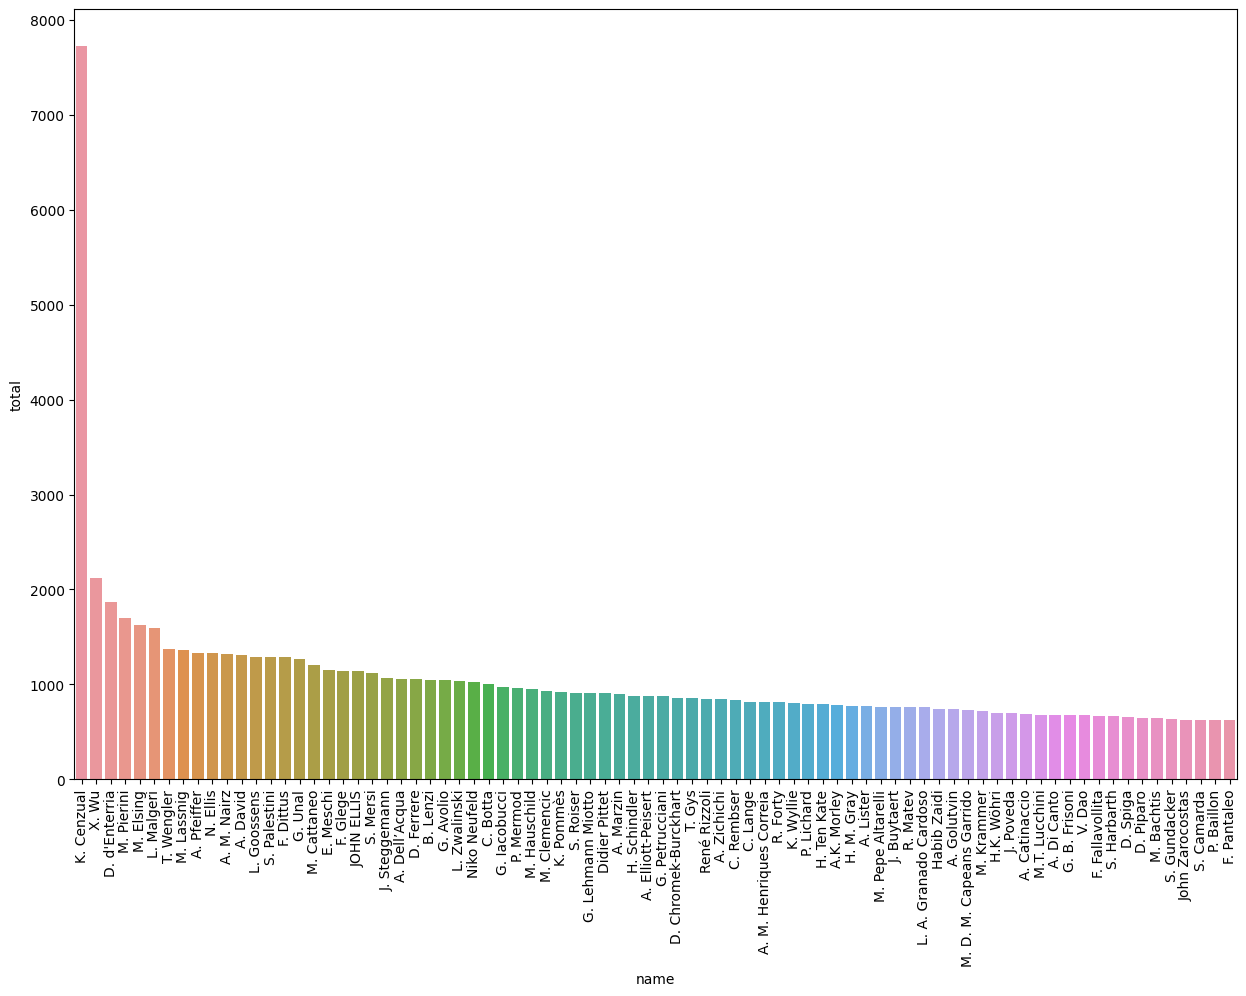

In [10]:
g = sns.barplot(x=result_total_publications["name"], y=result_total_publications["total"])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

## WHO IS K.CENZUAL????
When the data is weird like this, normally you investigate.

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [12]:
CENZUAL = gds.run_cypher("MATCH (n:Researcher{researcher_id:'ur.014174005714.85'})-[:WORKS_IN]-(f:Field) return n.full_name, n.last_name, n.total_number_of_publications, collect(f.domain)")
CENZUAL

,n.full_name,n.last_name,n.total_number_of_publications,collect(f.domain)
0,K. Cenzual,Cenzual,7729,"[Paediatrics and Reproductive Medicine, Organic Chemistry, Resources Engineering and Extractive Metallurgy, Astronomical and Space Sciences, Geochemistry, Inorganic Chemistry, Biochemistry and Cell Biology, Condensed Matter Physics, Materials Engineering, Other Physical Sciences, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Other Chemical Sciences, Information Systems, Physical Chemistry (incl. Structural), Geology, Artificial Intelligence and Image Processing]"


### Number of publication in an domain of research

In [13]:
#Get the field which has the most publications
result_domain_count = gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN f.domain as domain, count(*) as number_time ORDER BY  number_time DESC LIMIT 40")
result_domain_count.head()

,domain,number_time
0,Clinical Sciences,15891
1,Public Health and Health Services,13093
2,"Atomic, Molecular, Nuclear, Particle and Plasma Physics",11692
3,Other Physical Sciences,11401
4,Biochemistry and Cell Biology,6294


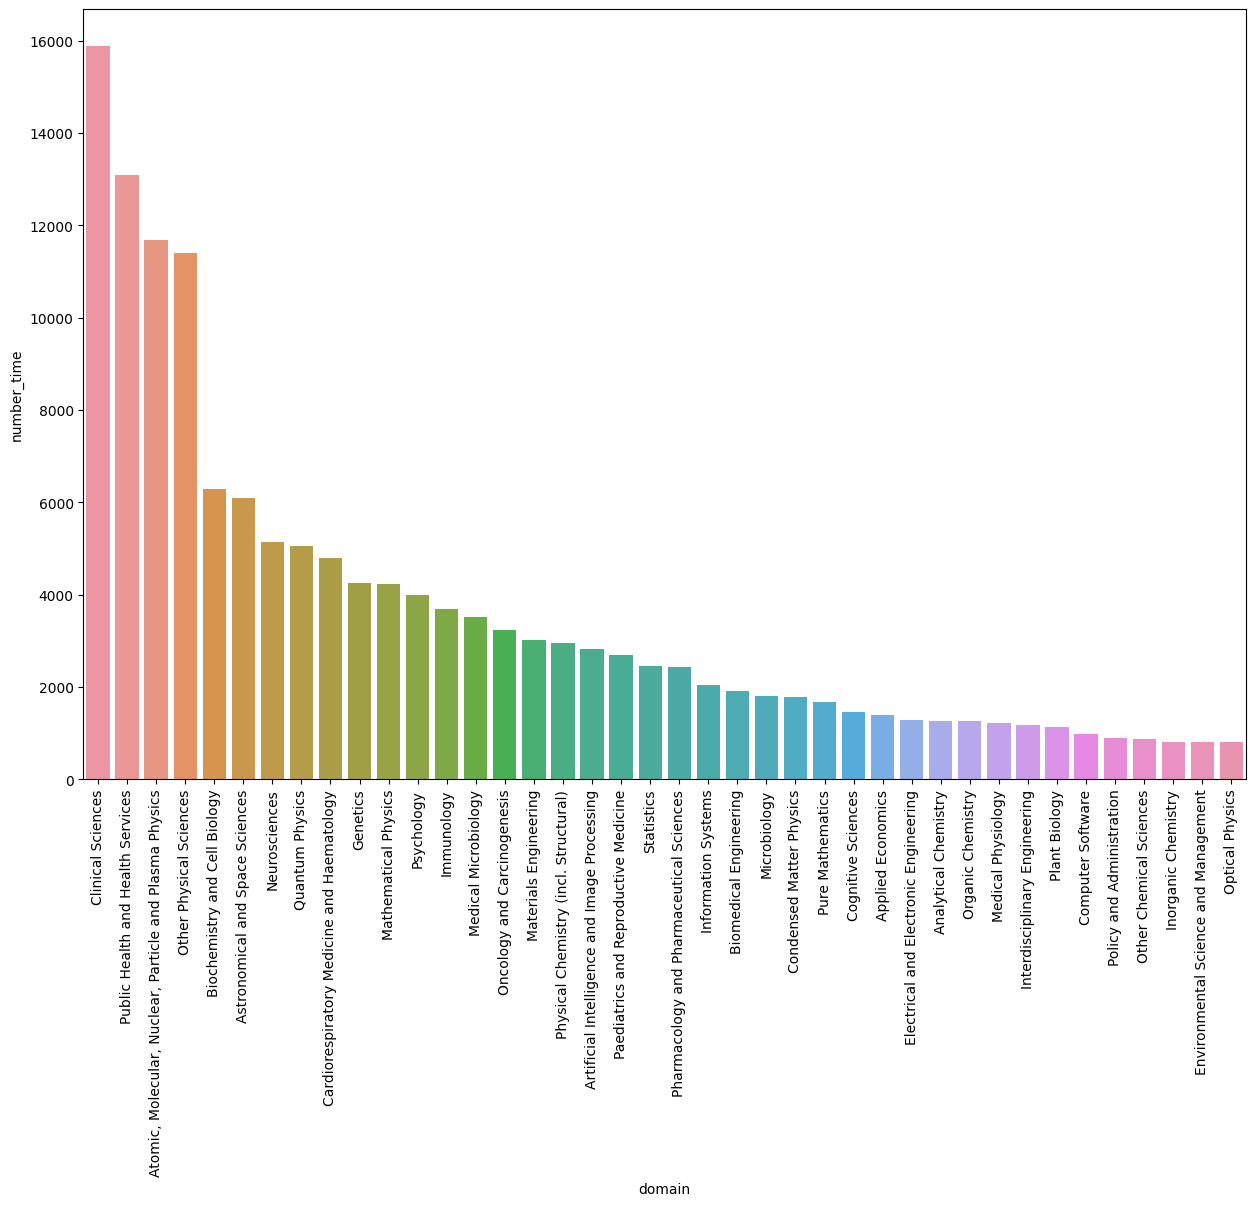

In [14]:
g = sns.barplot(x=result_domain_count["domain"], y=result_domain_count["number_time"])
g =g.set_xticklabels(g.get_xticklabels(), rotation=90)

### Who published in the most area of research

In [15]:
#Get the researcher that works in several research fields.
result_field = gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN r.full_name as name, r.researcher_id as researcher_id, count(*) as fields ORDER BY  fields DESC LIMIT 30")
result_field.head(10)

,name,researcher_id,fields
0,BASTIEN CHOPARD,ur.016275067565.80,46
1,S Rudaz,ur.0605706427.85,37
2,A. Zichichi,ur.012521521573.71,36
3,Jean-Charles Sanchez,ur.01326260071.22,32
4,Bernice S. Elger,ur.01306617426.43,31
5,François R. Herrmann,ur.01206175026.02,31
6,Vera I. Slaveykova,ur.01304222144.30,30
7,Martin K. Patel,ur.01205731332.31,30
8,Jean-Luc Wolfender,ur.01001572401.77,29
9,Markus Stoffel,ur.0753645627.41,28


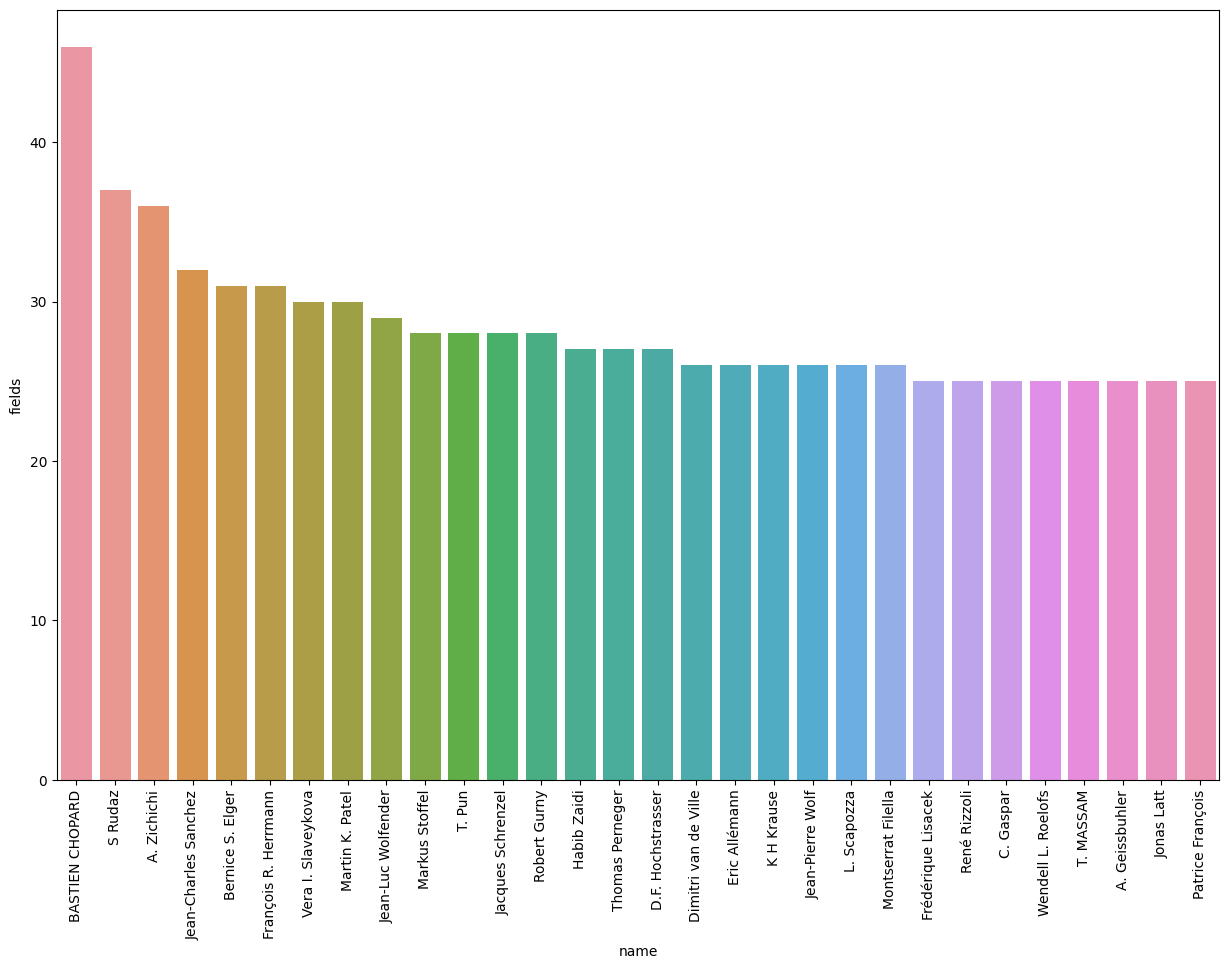

In [16]:
g = sns.barplot(x=result_field["name"], y=result_field["fields"])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [17]:
choppard = gds.run_cypher("MATCH (r:Researcher{researcher_id:'ur.016275067565.80'})-[w:WORKS_IN]-(f:Field) RETURN r.full_name as full_name, count(*) as total_fields, collect(f.domain) as domain")

print(choppard.domain)

0    [Maritime Engineering, Civil Engineering, Distributed Computing, Statistics, Applied Economics, Geomatic Engineering, Other Chemical Sciences, Theoretical and Computational Chemistry, Inorganic Chemistry, Cognitive Sciences, Genetics, Physiology, Banking, Finance and Investment, Physical Chemistry (incl. Structural), Interdisciplinary Engineering, Quantum Physics, Geology, Chemical Engineering, Environmental Engineering, Optical Physics, Information Systems, Materials Engineering, Zoology, Clinical Sciences, Communications Technologies, Physical Geography and Environmental Geoscience, Medical Physiology, Organic Chemistry, Numerical and Computational Mathematics, Data Format, Econometrics, Cardiorespiratory Medicine and Haematology, Biomedical Engineering, Artificial Intelligence and Image Processing, Computation Theory and Mathematics, Applied Mathematics, Mechanical Engineering, Biochemistry and Cell Biology, Geophysics, Computer Software, Pure Mathematics, Human Movement and Sp

## Computer science

## Scientists with the most publications in Computer Science (areas)

In [18]:
#Get the researcher with the most publications in Computer Science 

query_number_publications_in_computer_science_person =f"MATCH(r:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} \
    and w.weight_field > 1 return distinct r.full_name as name,r.researcher_id as researcher_id, r.total_number_of_publications as total_publication ORDER by r.total_number_of_publications DESC"

result_number_publication_person_computer_science = gds.run_cypher(query_number_publications_in_computer_science_person)
result_number_publication_person_computer_science.head(20)

,name,researcher_id,total_publication
0,Habib Zaidi,ur.01300453230.34,741
1,Nadia Magnenat-Thalmann,ur.0704711431.38,533
2,Dimitri van de Ville,ur.01041204034.82,418
3,BASTIEN CHOPARD,ur.016275067565.80,339
4,Amos Bairoch,ur.01076543625.00,233
5,Osman Ratib,ur.0617321230.19,230
6,Henning Müller,ur.07552063233.67,218
7,T. Pun,ur.01212142027.87,212
8,Christian Lovis,ur.01133331655.52,196
9,Frédérique Lisacek,ur.0674012177.79,195


In [19]:
query_informatique_fields = (f"MATCH(n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain \
     IN {field_computer_science}  RETURN DISTINCT n.full_name, n.researcher_id as researcher, f.domain, w.weight_field ORDER by w.weight_field DESC")

result_informatique_field = gds.run_cypher(query_informatique_fields)
result_informatique_field.head(10)

,n.full_name,researcher,f.domain,w.weight_field
0,Henning Müller,ur.07552063233.67,Artificial Intelligence and Image Processing,11.605505
1,Nadia Magnenat-Thalmann,ur.0704711431.38,Artificial Intelligence and Image Processing,11.227017
2,T. Pun,ur.01212142027.87,Artificial Intelligence and Image Processing,10.566038
3,Nadia Magnenat Thalmann,ur.013317560667.45,Artificial Intelligence and Image Processing,7.442748
4,Stéphane Marchand-Maillet,ur.016472056171.12,Artificial Intelligence and Image Processing,7.264368
5,Michel Leonard,ur.01066422007.20,Information Systems,7.183673
6,Habib Zaidi,ur.01300453230.34,Artificial Intelligence and Image Processing,6.558704
7,P. Volino,ur.07527316741.46,Artificial Intelligence and Image Processing,6.176471
8,M. Hilario,ur.010323216605.25,Artificial Intelligence and Image Processing,6.139535
9,Patrick Ruch,ur.016176475704.89,Artificial Intelligence and Image Processing,6.055046


In [20]:
#Get the researcher that works in several research fields.
result_field = gds.run_cypher(f"MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain \
IN {field_computer_science} and w.weight_field > 5 with r,f,w MATCH (r)-[ww:WORKS_IN]-(ff:Field)  \
RETURN r.full_name,r.researcher_id as researcher_id, r.total_number_of_publications as total_publication,max(w.weight_field) as max_weight_field, \
collect( DISTINCT f.domain) as domain_computer, \
count(ff.domain) as count_all_domain, collect(ff.domain) as all_domain  \
ORDER BY total_publication DESC ")
result_field.head(20)

,r.full_name,researcher_id,total_publication,max_weight_field,domain_computer,count_all_domain,all_domain
0,Habib Zaidi,ur.01300453230.34,741,6.558704,[Artificial Intelligence and Image Processing],27,"[Physiology, Astronomical and Space Sciences, Artificial Intelligence and Image Processing, Pharmacology and Pharmaceutical Sciences, Optical Physics, Biochemistry and Cell Biology, Materials Engineering, Theoretical and Computational Chemistry, Statistics, Other Physical Sciences, Information Systems, Paediatrics and Reproductive Medicine, Public Health and Health Services, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Electrical and Electronic Engineering, Oncology and Carcinogenesis, Numerical and Computational Mathematics, Medical Physiology, Clinical Sciences, Cardiorespiratory Medicine and Haematology, Human Movement and Sports Science, Psychology, Biomedical Engineering, Computation Theory and Mathematics, Neurosciences, Cognitive Sciences, Computer Software]"
1,Nadia Magnenat-Thalmann,ur.0704711431.38,533,11.227017,[Artificial Intelligence and Image Processing],22,"[Manufacturing Engineering, Artificial Intelligence and Image Processing, Information Systems, Computer Software, Materials Engineering, Statistics, Electrical and Electronic Engineering, Architecture, Curatorial and Related Studies, Psychology, Numerical and Computational Mathematics, Biomedical Engineering, Computation Theory and Mathematics, Design Practice and Management, Specialist Studies In Education, Neurosciences, Human Movement and Sports Science, Cognitive Sciences, Mechanical Engineering, Clinical Sciences, Curriculum and Pedagogy, Cultural Studies]"
2,Henning Müller,ur.07552063233.67,218,11.605505,[Artificial Intelligence and Image Processing],23,"[Cognitive Sciences, Computer Software, Communications Technologies, Psychology, Neurosciences, Information Systems, Biochemistry and Cell Biology, Cardiorespiratory Medicine and Haematology, Oncology and Carcinogenesis, Human Movement and Sports Science, Public Health and Health Services, Biomedical Engineering, Analytical Chemistry, Data Format, Electrical and Electronic Engineering, Linguistics, Medical Biotechnology, Distributed Computing, Clinical Sciences, Statistics, Computation Theory and Mathematics, Other Biological Sciences, Artificial Intelligence and Image Processing]"
3,T. Pun,ur.01212142027.87,212,10.566038,[Artificial Intelligence and Image Processing],28,"[Pure Mathematics, Civil Engineering, Artificial Intelligence and Image Processing, Cultural Studies, Information Systems, Computer Software, Biomedical Engineering, Psychology, Communications Technologies, Computation Theory and Mathematics, Cardiorespiratory Medicine and Haematology, Environmental Science and Management, Statistics, Other Physical Sciences, Medical Biotechnology, Applied Economics, Electrical and Electronic Engineering, Design Practice and Management, Cognitive Sciences, Clinical Sciences, Other Biological Sciences, Film, Television and Digital Media, Dentistry, Data Format, Neurosciences, Distributed Computing, Optical Physics, Medical Biochemistry and Metabolomics]"
4,Stéphane Marchand-Maillet,ur.016472056171.12,174,7.264368,"[Information Systems, Artificial Intelligence and Image Processing]",32,"[Computer Software, Psychology, Geomatic Engineering, Ecology, Architecture, Data Format, Pure Mathematics, Public Health and Health Services, Computation Theory and Mathematics, Statistics, Information Systems, Econometrics, Environmental Science and Management, Artificial Intelligence and Image Processing, Electrical and Electronic Engineering, Archaeology, Computer Software, Psychology, Geomatic Engineering, Ecology, Architecture, Data Format, Pure Mathematics, Public Health and Health Services, Computation Theory and Mathematics, Statistics, Information Systems, Econometrics, Environmental Science and Management, Artificial Intelligence and Image Processing, Electrical and Electronic Engineering, Archaeology

## Start of the Recommender 

## Start for the graph algorithms to skip if these relationships are already in the DB

In [21]:
graph_name = "co_authors_graph"

In [22]:
result = gds.run_cypher("""CALL gds.graph.drop($params,false) YIELD graphName""",params={"params":graph_name}) # drop the graph and do not raise the error if the graph is not found.
result = gds.run_cypher("""CALL gds.graph.project($params, 'Researcher', 'CO_AUTHORS')""",params={"params":graph_name})
result

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Researcher': {'label': 'Researcher', 'properties': {}}}","{'CO_AUTHORS': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'CO_AUTHORS', 'properties': {}}}",co_authors_graph,64849,697374,543


## Centrality
Utiliser les algorithmes de centralités pour calculer les chercheurs qui ont plus de connection (plus important) que d'autres. Ceci pourrait être utiliser plus tard pour classifier les reviewers.

### Calculate the Degree Centrality

In [23]:
#Stream the result for the degree centrality 

result = gds.run_cypher(
f" CALL gds.degree.stream($params) YIELD nodeId, score RETURN gds.util.asNode(nodeId).full_name AS name, score ORDER BY score DESC, name ASC", params={"params":graph_name}
)
result.head()

,name,score
0,M. Elsing,1811.0
1,N. Ellis,1674.0
2,T. Wengler,1626.0
3,F. Dittus,1623.0
4,A. M. Nairz,1574.0


In [24]:
#write the data in the graph
result = gds.run_cypher(f"CALL gds.degree.write($params_graph, {{writeProperty: 'degree_centrality'}})",params={"params_graph":graph_name})
result


,nodePropertiesWritten,centralityDistribution,writeMillis,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,64849,"{'p99': 144.00096893310547, 'min': 0.0, 'max': 1811.0078048706055, 'mean': 10.75384267551621, 'p90': 18.00011444091797, 'p50': 1.0, 'p999': 993.0038986206055, 'p95': 40.00023651123047, 'p75': 6.000022888183594}",118,254,0,0,"{'jobId': '972fb672-ebbe-45ee-9f23-524e68aba361', 'orientation': 'NATURAL', 'writeConcurrency': 4, 'writeProperty': 'degree_centrality', 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}"


### Difference between centrality and betweeeness measures

Degree centrality measures the number of incoming or outgoing (or both) relationships from a node, depending on the orientation of a relationship projection.

Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

In [25]:
# #difficult to run on AURO DS
# result_betweeness = gds.run_cypher(
# f" CALL gds.betweenness.write($params_graph, {{writeProperty: 'betweeness'}})",params={"params_graph":graph_name})
# result_betweeness


### Calculate PageRank
The PageRank algorithm measures the importance of each node within the graph, based on the number 
incoming relationships and the importance of the corresponding source nodes. 
The underlying assumption roughly speaking is that a page is only as important as the pages that link to it.


In [26]:
result_page_rank_stream = gds.run_cypher(
f" CALL gds.pageRank.stream($params)\
YIELD nodeId, score \
RETURN gds.util.asNode(nodeId).full_name AS name, score \
ORDER BY score DESC, name ASC" , params={"params":graph_name}
)
result_page_rank_stream.head(10)

,name,score
0,H. J. Stelzer,31.803249
1,K. Schmieden,17.394491
2,G. Anders,16.506594
3,O. Arnaez,12.033890
4,A. Ruiz-Martinez,11.943163
5,P. O. Deviveiros,10.866444
6,P. S. Wells,9.867472
7,M. Mulders,9.106230
8,G. Sarpis,8.756139
9,A. Pfeiffer,8.673148


In [119]:
result_page_rank_write = gds.run_cypher(
f" CALL gds.pageRank.write($params_graph, {{writeProperty: 'pageRank',scaler:'L1NORM'}})",params={"params_graph":graph_name})
result_page_rank_write

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,191,64849,20,False,"{'p99': 6.944636697880924e-05, 'min': 7.229391485452652e-06, 'max': 0.0015327930159401149, 'mean': 1.5420434387881796e-05, 'p90': 2.7029047487303615e-05, 'p50': 1.1005235137417912e-05, 'p999': 0.00017695126007311046, 'p95': 3.6807003198191524e-05, 'p75': 1.7070764442905784e-05}",57,0,528,"{'jobId': 'dbb91322-49f9-4836-a88f-1e690cd2e22d', 'maxIterations': 20, 'writeConcurrency': 4, 'sourceNodes': [], 'writeProperty': 'pageRank', 'scaler': 'L1NORM', 'nodeLabels': ['*'], 'sudo': False, 'dampingFactor': 0.85, 'relationshipTypes': ['*'], 'tolerance': 1e-07, 'concurrency': 4}"


## Query the database for pageRank and Degree centrality

In [125]:
betweeness_page_rank_df = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} and \
    w.weight_field>1 return DISTINCT n.full_name, n.researcher_id, n.pageRank as pageRank,n.degree_centrality as centrality_score ORDER by pageRank DESC")
betweeness_page_rank_df

#centrality_df = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} and w.weight_field>3 return DISTINCT n.full_name,  n.researcher_id, n.degree_centrality as centrality_score ORDER by centrality_score  DESC")

,n.full_name,n.researcher_id,pageRank,centrality_score
0,Zhiyong Lu,ur.01074355715.83,0.000068,22.0
1,Cristina Vazquez-Velez,ur.015724424625.10,0.000063,0.0
2,Stefan Wunsch,ur.013613064120.91,0.000059,1.0
3,Manuel Corpas,ur.0663634752.75,0.000051,7.0
4,Mian Muhammad Naeem Abid,ur.014566677342.00,0.000051,0.0
...,...,...,...,...
841,P. Zanella,ur.010360044113.49,0.000007,0.0
842,Davide A. Cucci,ur.010360010265.01,0.000007,1.0
843,ABDERRAHIM LABBI,ur.010225342465.76,0.000007,3.0
844,Benjamin Hughes,ur.010141223757.14,0.000007,0.0


In [72]:
# scaler = StandardScaler()
# betweeness_page_rank_df.iloc[:,2:] = scaler.fit_transform(betweeness_page_rank_df.iloc[:,2:].to_numpy())
# betweeness_page_rank_df

,n.full_name,n.researcher_id,pageRank,centrality_score
0,Zhiyong Lu,ur.01074355715.83,8.265128,0.265937
1,Cristina Vazquez-Velez,ur.015724424625.10,7.396226,-0.491581
2,Stefan Wunsch,ur.013613064120.91,6.908979,-0.457148
3,Manuel Corpas,ur.0663634752.75,5.750192,-0.250552
4,Mian Muhammad Naeem Abid,ur.014566677342.00,5.666444,-0.491581
...,...,...,...,...
841,P. Zanella,ur.010360044113.49,-0.706094,-0.491581
842,Davide A. Cucci,ur.010360010265.01,-0.706094,-0.457148
843,ABDERRAHIM LABBI,ur.010225342465.76,-0.706094,-0.388283
844,Benjamin Hughes,ur.010141223757.14,-0.706094,-0.491581


In [68]:
#betweeness_page_rank_df.iloc[:,2:]= betweeness_page_rank_df.iloc[:,2:].transform(lambda x: x / abs(x).max())

In [126]:
betweeness_page_rank_df.fillna(0,inplace=True)
betweeness_page_rank_df_graph = betweeness_page_rank_df.set_index("n.full_name")

In [128]:
betweeness_page_rank_df_graph.sort_values(by="centrality_score",ascending=False,inplace=True)

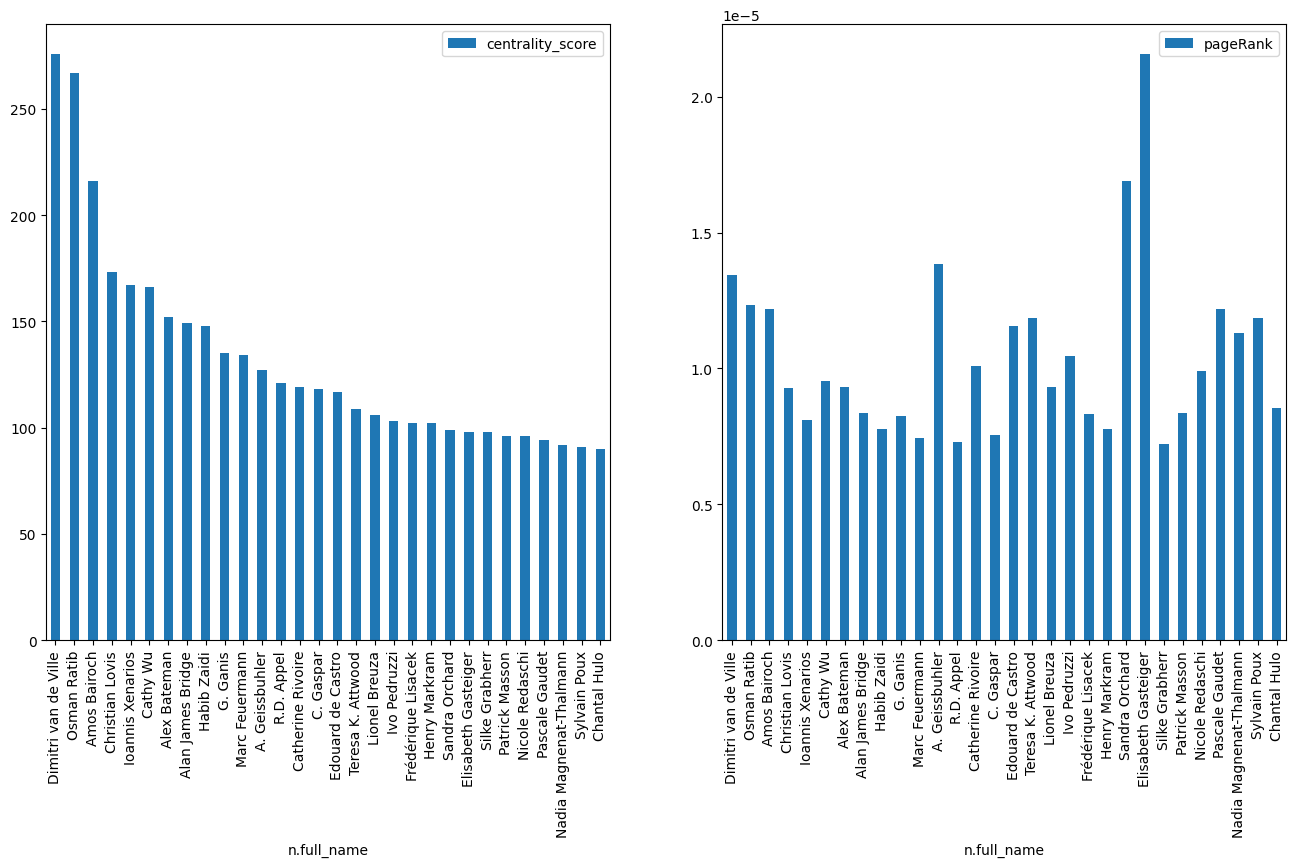

In [129]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
betweeness_page_rank_df_graph[["centrality_score"]].head(30).plot(kind="bar", ax=ax1)
betweeness_page_rank_df_graph[["pageRank"]].head(30).plot(kind="bar",ax=ax2)
a = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

The Degree Centrality algorithm counts the number of incoming and outgoing relationships from a node. It is used to find popular nodes in a graph.

PageRank is a variant of the Eigenvector Centrality algorithm which measures the transitive (or directional) influence of nodes. Relationships to high-scoring nodes contribute more to the score of a node than connections to low-scoring nodes. A high score means that a node is connected to other nodes that have high scores.

On peut remarquer que les mesures ne donnent pas les mêmes résultats. La question est de savoir quel algorithmes choisir, et cela se fait en fonction de ce que l'on veut faire, et des hypotheses de départ.
Par exemple, si on recherche un scientifique qui est un hub on va choisir Betweenness Centrality comme algorithme.
Entre ces deux exemples, PageRank et centrality, on voit que certains scientifiques on un score PageRank plus haut que leur score de centrality, ou plus bas. Cela pourrait être du au fait que les personnes avec qui ces scientifiques collaborent sont des personnes qui sont "importante" ou peu "importante". Un·e scientifique qui collabore surtout avec des étudiants en Doctorat va avoir un PageRank score plus bas que quelqu'un qui collabore surtout avec des scientifiques de renoms.

In [131]:
betweeness_page_rank_df_graph[betweeness_page_rank_df_graph.index.str.startswith("Jean-Henry")]


,n.researcher_id,pageRank,centrality_score
n.full_name,,,
Jean-Henry Morin,ur.0631021307.20,0.000011,6.0


In [132]:
betweeness_page_rank_df_graph[betweeness_page_rank_df_graph.index.str.startswith("Hélène")]

,n.researcher_id,pageRank,centrality_score
n.full_name,,,
Hélène de Ribaupierre,ur.01276566337.02,0.000008,0.0


In [133]:
betweeness_page_rank_df_graph[betweeness_page_rank_df_graph.index.str.startswith("Nadia Magnenat-Thalmann")]

,n.researcher_id,pageRank,centrality_score
n.full_name,,,
Nadia Magnenat-Thalmann,ur.0704711431.38,0.000011,92.0


## COMMUNITY

The Label Propagation algorithm (LPA) is a fast algorithm for finding communities in a graph. It detects these communities using network structure alone as its guide, and doesn’t require a pre-defined objective function or prior information about the communities.
LPA works by propagating labels throughout the network and forming communities based on this process of label propagation.
The intuition behind the algorithm is that a single label can quickly become dominant in a densely connected group of nodes, but will have trouble crossing a sparsely connected region. Labels will get trapped inside a densely connected group of nodes, and those nodes that end up with the same label when the algorithms finish can be considered part of the same community.

The Louvain method is an algorithm to detect communities in large networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network. (source neo4j)

In [37]:
graph_name_2 = "co_authors_graph_weight"
result = gds.run_cypher("""CALL gds.graph.drop($params,false) YIELD graphName""",params={"params":graph_name_2}) # drop the graph and do not raise the error if the graph is not found.
result = gds.run_cypher("""CALL gds.graph.project('co_authors_graph_weight', 'Researcher', {CO_AUTHORS:{properties:"number_of_time"}})""",params={"params":graph_name_2})
result

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Researcher': {'label': 'Researcher', 'properties': {}}}","{'CO_AUTHORS': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'CO_AUTHORS', 'properties': {'number_of_time': {'defaultValue': None, 'property': 'number_of_time', 'aggregation': 'DEFAULT'}}}}",co_authors_graph_weight,64849,697374,1055


In [38]:
#LabelPropation with weight
gds.run_cypher("""CALL gds.labelPropagation.stats($graph_name,{maxIterations:22})
YIELD communityCount, ranIterations, didConverge""",params={"graph_name":graph_name_2})

,communityCount,ranIterations,didConverge
0,23437,15,True


In [39]:
#labelPropagation without weight
gds.run_cypher("""CALL gds.labelPropagation.stats($graph_name,{maxIterations:22})
YIELD communityCount, ranIterations, didConverge""",params={"graph_name":graph_name})


,communityCount,ranIterations,didConverge
0,23437,15,True


In [40]:
gds.run_cypher("""CALL gds.labelPropagation.stream($graph_name,{relationshipWeightProperty:"number_of_time",maxIterations:20})
YIELD nodeId, communityId AS Community
RETURN gds.util.asNode(nodeId).full_name AS Name, Community
ORDER BY Community, Name""",params={"graph_name":graph_name_2})

,Name,Community
0,Carl Bader,22939
1,Georg Arx,22946
2,Dragana Djurdjevic,22957
3,C. Smith,22965
4,D. H. Dunham,22965
...,...,...
64844,J.M. Kipela,101097
64845,M. Cole,101098
64846,Mathieu Grobéty,101099
64847,PAOLO FIALLO,101100


In [41]:
#Louvain with weight
gds.run_cypher("""
CALL gds.louvain.stats($graph_name,{relationshipWeightProperty:"number_of_time",maxIterations:22})
YIELD communityCount""",params={"graph_name":graph_name_2})

,communityCount
0,16485


In [42]:
#Louvain without weight
gds.run_cypher("""
CALL gds.louvain.stats($graph_name)
YIELD communityCount""",params={"graph_name":graph_name_2})

,communityCount
0,15365


In [43]:
# Label propagation
gds.run_cypher("""CALL gds.labelPropagation.stream($graph_name,{relationshipWeightProperty:"number_of_time",maxIterations:20})
YIELD nodeId, communityId AS Community
RETURN gds.util.asNode(nodeId).full_name AS Name, Community
ORDER BY Community, Name""",params={"graph_name":graph_name_2})

,Name,Community
0,Carl Bader,22939
1,Georg Arx,22946
2,Dragana Djurdjevic,22957
3,C. Smith,22965
4,D. H. Dunham,22965
...,...,...
64844,J.M. Kipela,101097
64845,M. Cole,101098
64846,Mathieu Grobéty,101099
64847,PAOLO FIALLO,101100


In [44]:
#LOUVAIN

gds.run_cypher("""
CALL gds.louvain.stream($graph_name)
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).full_name AS full_name, communityId, intermediateCommunityIds
ORDER BY full_name ASC""",params={"graph_name":graph_name_2})



,full_name,communityId,intermediateCommunityIds
0,4 Gualtiero Palareti3,54546,None
1,A A Pol,42103,None
2,A ANDRIANAKI,58859,None
3,A Abad Rodriguez,63644,None
4,A Abramov,55469,None
...,...,...,...
64844,Ž. Srdić,59934,None
64845,Žiga Rotar,56018,None
64846,Åsa Holm,51627,None
64847,Åsa Rasmuson-Lestander,41191,None


In [45]:
result_write_louvain = gds.run_cypher("""
CALL gds.louvain.write($graph_name,{relationshipWeightProperty:"number_of_time", writeProperty:"louvain"})
YIELD communityCount, modularity, modularities""",params={"graph_name":graph_name_2})
result_write_louvain.head()


,communityCount,modularity,modularities
0,16548,0.665353,"[0.4263892878771428, 0.6190704411214452, 0.6540421383461018, 0.6603497323056917, 0.6625744139782466, 0.6639257246270884, 0.6647914404901931, 0.6650817335133626, 0.6653534695474569]"


In [46]:
graph_name_3 = "field_weight"
result = gds.run_cypher("""CALL gds.graph.drop($params,false) YIELD graphName""",params={"params":graph_name_3}) # drop the graph and do not raise the error if the graph is not found.
result = gds.run_cypher("""CALL gds.graph.project($params, 'Researcher','WORKS_IN_SIMILAR_AREA')""",params={"params":graph_name_3})
result

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Researcher': {'label': 'Researcher', 'properties': {}}}","{'WORKS_IN_SIMILAR_AREA': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'WORKS_IN_SIMILAR_AREA', 'properties': {}}}",field_weight,64849,1212027,647


In [47]:
gds.run_cypher("""
CALL gds.louvain.stream($graph_name)
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).full_name AS full_name, communityId, intermediateCommunityIds
ORDER BY full_name ASC""",params={"graph_name":graph_name_3})

,full_name,communityId,intermediateCommunityIds
0,4 Gualtiero Palareti3,54546,None
1,A A Pol,2558,None
2,A ANDRIANAKI,46622,None
3,A Abad Rodriguez,42258,None
4,A Abramov,19541,None
...,...,...,...
64844,Ž. Srdić,24868,None
64845,Žiga Rotar,44557,None
64846,Åsa Holm,47499,None
64847,Åsa Rasmuson-Lestander,47499,None


In [48]:
result_write_louvain_field = gds.run_cypher("""
CALL gds.louvain.write($graph_name,{ writeProperty:"louvain_field"})
YIELD communityCount, modularity, modularities""",params={"graph_name":graph_name_3})
result_write_louvain_field.head()

,communityCount,modularity,modularities
0,56159,0.606115,"[0.5705135732742378, 0.6061147179539055]"


# Begining of the query for the result

In [49]:
louvain_df = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} and \
w.weight_field>2 return DISTINCT n.full_name, n.louvain as louvain ORDER by louvain DESC")
louvain_df_group = (
        louvain_df.groupby("louvain")
        .agg(co_authors_list=("n.full_name", "unique"))
        .reset_index()
    )
louvain_df_group

,louvain,co_authors_list
0,1876,[Michel Lauria]
1,2249,[Cedric Crettaz]
2,4125,"[Nicolas Zufferey, C. Bryce, Dimitri Konstantas, Jean-Henry Morin, Chrislain Razafimahefa, Naoufel Cheikhrouhou, Michel Deriaz, Verena Kantere, Katarzyna Wac, Matteo Ciman, Simon Thevenin]"
3,4855,[Yves Wiaux]
4,6054,[Luis Pedro]
5,6833,[Gregg Vanderheiden]
6,14970,[Yin Wu]
7,17653,[P. Frey]
8,24064,[L. Cardoso]
9,26292,[Gilbert Ritschard]


### Louvain by CO_AUTHORS

In [146]:
#return the community of two scientists
louvain_2_scientists = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) \
WHERE n.full_name=$researcher_1 return DISTINCT n.full_name, n.louvain as louvain \
UNION \
MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) \
WHERE n.full_name=$researcher_2 return DISTINCT n.full_name, n.louvain as louvain",params={"researcher_1":researcher_1,"researcher_2":researcher_2})
louvain_2_scientists

,n.full_name,louvain
0,Jean-Henry Morin,4125
1,Gilles Falquet,54472


In [145]:
#return the researcher that are in the same community than both scientists
louvain_for_the_authors = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE n.louvain IN {louvain_2_scientists.louvain.tolist()} \
RETURN DISTINCT n.full_name as full_name, n.researcher_id as researcher_id, n.louvain")
louvain_for_the_authors.head(20)

,full_name,researcher_id,n.louvain
0,Paul R. Hunter,ur.01255356036.46,54472
1,Michel Leonard,ur.01066422007.20,54472
2,Simona Zipursky,ur.01145320545.18,54472
3,Alejandro Ramirez Gonzalez,ur.013065015327.56,54472
4,Emily Wootton,ur.010031000127.92,54472
5,Omar Benkacem,ur.012406460341.25,54472
6,Suzanne Scheele,ur.01057413767.46,54472
7,E Krug,ur.01026100535.25,54472
8,E Allanson,ur.016340266524.30,54472
9,Ö Tunçalp,ur.01106661663.19,54472


### LOUVAIN BY FIELD

In [147]:
louvain_2_scientists_field = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) \
WHERE n.full_name=$researcher_1 return DISTINCT n.full_name, n.louvain_field as louvain_field \
UNION \
MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) \
WHERE n.full_name=$researcher_2 return DISTINCT n.full_name, n.louvain_field as louvain_field",params={"researcher_1":researcher_1,"researcher_2":researcher_2})
louvain_2_scientists_field

,n.full_name,louvain_field
0,Jean-Henry Morin,1579
1,Gilles Falquet,1579


In [148]:
#return the researcher that are in the same community than both scientists
louvain_other_field = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE n.louvain_field IN {louvain_2_scientists_field.louvain_field.tolist()} \
RETURN DISTINCT n.full_name as full_name, n.researcher_id as researcher_id, n.louvain_field")
print(louvain_other_field.shape)
louvain_other_field.head(20)

(1498, 3)


,full_name,researcher_id,n.louvain_field
0,Emmanouil T. Dermitzakis,ur.01204470014.51,1579
1,Sébastien Ziegler,ur.013523127674.95,1579
2,K H Krause,ur.01132215437.58,1579
3,C. Bonadonna,ur.07732455104.21,1579
4,Donald Glowinski,ur.07567302507.39,1579
5,Michel Leonard,ur.01066422007.20,1579
6,Manfred Gilli,ur.010700105653.02,1579
7,Elvezio Ronchetti,ur.012507417265.19,1579
8,T. O. Niinikoski,ur.010674443035.14,1579
9,A. Rijllart,ur.01000325115.53,1579


## Inference avec la règle
∀x ∀y ∀z ∀f,
co_authors(x,y) ∧
co_authors(y,z) ∧
works_in(x,f) ∧
works_in(z,f) ∧
(weight(z,f)-n) <=
(weight(x,f)<=
(weight(z,f)+n) ∧
(works_in(x,f)>n) ->
possible_reviewers(𝑥,𝑧)


In [54]:
#Paper written by 2 scientists
difference_weight_field=10
minimum_weight_field=1.0

result_inference = gds.run_cypher(f"UNWIND $full_name as full_name\
        MATCH (res_1:Researcher{{full_name:full_name}}) CALL apoc.neighbors.athop(res_1, 'CO_AUTHORS', 2) \
        yield node as res_2  \
        MATCH (res_1)-[w_1:WORKS_IN]->(f:Field) \
        MATCH (res_2)-[w_2:WORKS_IN]->(f:Field) \
        WHERE (w_2.weight_field-$difference_weight_field)<= w_1.weight_field <=(w_2.weight_field+$difference_weight_field) \
        AND w_1.weight_field > $minimum_weight_field \
        and res_1 <> res_2 \
        RETURN DISTINCT res_1.full_name as full_name_author, res_2.full_name as reviewer_full_name,res_2.researcher_id as reviewer_id, round((w_2.weight_field+w_1.weight_field)/2,3) as score \
        ",params={"full_name":[researcher_1,researcher_2],"difference_weight_field":difference_weight_field,"minimum_weight_field":minimum_weight_field})
result_tmp = result_inference.groupby(["reviewer_id"]).sum("score")
result_merged = result_tmp.merge(result_inference,on="reviewer_id").drop(columns="score_y").rename(columns={"score_x":"score"}).drop_duplicates()
result_merged.sort_values(by="score",ascending=False,inplace=True)
print(result_merged.shape)
result_merged.head(10)

(216, 4)


,reviewer_id,score,full_name_author,reviewer_full_name
259,ur.0704711431.38,14.352,Jean-Henry Morin,Nadia Magnenat-Thalmann
261,ur.0704711431.38,14.352,Gilles Falquet,Nadia Magnenat-Thalmann
287,ur.07552063233.67,11.447,Gilles Falquet,Henning Müller
155,ur.013317560667.45,11.164,Jean-Henry Morin,Nadia Magnenat Thalmann
157,ur.013317560667.45,11.164,Gilles Falquet,Nadia Magnenat Thalmann
284,ur.07527316741.46,9.674,Gilles Falquet,P. Volino
283,ur.07527316741.46,9.674,Jean-Henry Morin,P. Volino
136,ur.012722422737.80,9.051,Jean-Henry Morin,I. Pandzic
138,ur.012722422737.80,9.051,Gilles Falquet,I. Pandzic
223,ur.016176475704.89,8.784,Gilles Falquet,Patrick Ruch


### Merge the louvain by CO_AUTHORS with the result of the inference function

In [149]:
result_merged_louvain_inference = result_inference.merge(louvain_for_the_authors, left_on="reviewer_id",right_on="researcher_id").drop(columns=["researcher_id","full_name"]).sort_values(by="n.louvain")
print(result_merged_louvain_inference.shape)
result_merged_louvain_inference


(42, 5)


,reviewer_id,score,full_name_author,reviewer_full_name,n.louvain
20,ur.016265667045.20,2.900,Jean-Henry Morin,Panagiotis Kostopoulos,4125
37,ur.014425412436.05,2.261,Jean-Henry Morin,Shervin Zakeri,4125
36,ur.07757411733.02,2.395,Jean-Henry Morin,Grigorios G. Anagnostopoulos,4125
34,ur.015035357673.88,2.511,Jean-Henry Morin,Tiago Nunes,4125
33,ur.013174534254.17,2.511,Jean-Henry Morin,Alfredo A. Villalba Castro,4125
32,ur.010360176245.76,2.636,Jean-Henry Morin,Athanasios I. Kyritsis,4125
31,ur.012151210713.91,2.677,Jean-Henry Morin,Alfredo Villalba,4125
30,ur.0674315747.20,2.725,Jean-Henry Morin,Christiana Tsiourti,4125
29,ur.010764050654.47,2.761,Jean-Henry Morin,Maxim Filatov,4125
21,ur.015366767021.17,2.868,Jean-Henry Morin,Michel Pawlak,4125


### Merge the result of the inference+louvain with the betweeness and centrality result


In [155]:
final_merged = result_merged_louvain_inference.merge(betweeness_page_rank_df,right_on="n.researcher_id",left_on="reviewer_id")
final_merged.head(20)

,reviewer_id,score,full_name_author,reviewer_full_name,n.louvain,n.full_name,n.researcher_id,pageRank,centrality_score
0,ur.016265667045.20,2.900,Jean-Henry Morin,Panagiotis Kostopoulos,4125,Panagiotis Kostopoulos,ur.016265667045.20,0.000008,3.0
1,ur.07757411733.02,2.395,Jean-Henry Morin,Grigorios G. Anagnostopoulos,4125,Grigorios G. Anagnostopoulos,ur.07757411733.02,0.000007,8.0
2,ur.010360176245.76,2.636,Jean-Henry Morin,Athanasios I. Kyritsis,4125,Athanasios I. Kyritsis,ur.010360176245.76,0.000011,2.0
3,ur.012151210713.91,2.677,Jean-Henry Morin,Alfredo Villalba,4125,Alfredo Villalba,ur.012151210713.91,0.000008,0.0
4,ur.0674315747.20,2.725,Jean-Henry Morin,Christiana Tsiourti,4125,Christiana Tsiourti,ur.0674315747.20,0.000009,9.0
5,ur.010764050654.47,2.761,Jean-Henry Morin,Maxim Filatov,4125,Maxim Filatov,ur.010764050654.47,0.000008,0.0
6,ur.015366767021.17,2.868,Jean-Henry Morin,Michel Pawlak,4125,Michel Pawlak,ur.015366767021.17,0.000018,0.0
7,ur.012355324276.13,3.169,Jean-Henry Morin,Michel Deriaz,4125,Michel Deriaz,ur.012355324276.13,0.000009,14.0
8,ur.016055002233.13,3.961,Jean-Henry Morin,Naoufel Cheikhrouhou,4125,Naoufel Cheikhrouhou,ur.016055002233.13,0.000009,6.0
9,ur.07707347217.57,1.516,Jean-Henry Morin,Manuel Oriol,4125,Manuel Oriol,ur.07707347217.57,0.000010,0.0


In [156]:
def query_co_authors_by_name(names: list[str]):
        query = """
        UNWIND $researchers as name
        MATCH (r:Researcher{full_name: name})-[c:CO_AUTHORS]-(p:Researcher) 
        WHERE r<>p
        RETURN DISTINCT p.researcher_id,p.full_name
        """
        return gds.run_cypher(
            query,
            params={"researchers": names},
        )

In [157]:
co_authors = query_co_authors_by_name(result_merged_louvain_inference.full_name_author.drop_duplicates().tolist())
co_authors.head(10)

,p.researcher_id,p.full_name
0,ur.0643632165.06,Dimitri Konstantas
1,ur.013104610033.47,Katerina Stamou
2,ur.011260202163.33,Verena Kantere
3,ur.014140374103.20,Vassilis Prevelakis
4,ur.07350022537.69,C. Bryce
5,ur.015572001267.73,Antonella Longo
6,ur.014177040267.27,Mario Bochicchio
7,ur.015372375037.57,L. Moccozet
8,ur.010456151764.35,Jörn Erbguth
9,ur.015271360627.89,Matteo Risoldi


In [164]:
# FINAL result for possible reviewer and if p.researcher_id
final_result = final_merged.merge(co_authors,how="left",left_on="reviewer_id",right_on="p.researcher_id").fillna("0").sort_values(by="p.researcher_id",ascending=False)
final_result = final_result.drop(final_result[(final_result["p.full_name"]!="0")].index)
final_result = final_result.drop(final_result[(final_result["reviewer_full_name"].isin(researcher_list))].index)
final_result_col = ["full_name_author","reviewer_full_name","reviewer_id","score","n.louvain","pageRank","centrality_score"]

final_result[final_result_col].sort_values(by="score",ascending=False)


,full_name_author,reviewer_full_name,reviewer_id,score,n.louvain,pageRank,centrality_score
15,Jean-Henry Morin,Wanda Opprecht,ur.010515705775.36,6.319,54472,0.000016,1.0
16,Gilles Falquet,Wanda Opprecht,ur.010515705775.36,6.319,54472,0.000016,1.0
17,Gilles Falquet,Jolita Ralyté,ur.012265620367.64,5.682,54472,0.000008,5.0
18,Gilles Falquet,Abdelaziz Khadraoui,ur.07522265432.33,5.061,54472,0.000012,4.0
19,Gilles Falquet,Eric Wehrli,ur.01242625577.43,4.859,54472,0.000008,8.0
12,Jean-Henry Morin,Katarzyna Wac,ur.010234164203.55,4.746,4125,0.000008,21.0
10,Jean-Henry Morin,Chrislain Razafimahefa,ur.016103437533.00,4.339,4125,0.000010,1.0
8,Jean-Henry Morin,Naoufel Cheikhrouhou,ur.016055002233.13,3.961,4125,0.000009,6.0
23,Gilles Falquet,Anastasiya Yurchyshyna,ur.013646161477.93,3.183,54472,0.000008,2.0
7,Jean-Henry Morin,Michel Deriaz,ur.012355324276.13,3.169,4125,0.000009,14.0


In [159]:
# result_merged_louvain_inference_field = result_inference.merge(louvain_other_field, left_on="reviewer_id",right_on="researcher_id").drop(columns=["researcher_id","full_name"]).sort_values(by="n.louvain_field")
# print(result_merged_louvain_inference_field.shape)
# result_merged_louvain_inference_field.sort_values(by="score", ascending=False)

(112, 5)


,reviewer_id,score,full_name_author,reviewer_full_name,n.louvain_field
0,ur.0704711431.38,14.352,Jean-Henry Morin,Nadia Magnenat-Thalmann,1579
1,ur.0704711431.38,14.352,Gilles Falquet,Nadia Magnenat-Thalmann,1579
2,ur.07527316741.46,9.674,Gilles Falquet,P. Volino,1579
3,ur.07527316741.46,9.674,Jean-Henry Morin,P. Volino,1579
4,ur.012722422737.80,9.051,Jean-Henry Morin,I. Pandzic,1579
...,...,...,...,...,...
107,ur.011115412117.80,1.718,Gilles Falquet,Manuel Gonzalez-Berges,1579
108,ur.012724534541.88,1.685,Gilles Falquet,Nicolas Roduit,1579
109,ur.016000335747.25,1.615,Gilles Falquet,J. P. Wellisch,1579
110,ur.07707347217.57,1.516,Jean-Henry Morin,Manuel Oriol,1579
